# mmic
Here we walk through creating and visualizing protoplanetary disk initial conditions (ICs) for MANGA, the moving-mesh implementation in [ChaNGa](https://github.com/N-BodyShop/changa). This should not only serve as a tutorial for using mmic, but also as an (in no way comprehensive) overview of making MANGA ICs in general.

The procedure for generating MANGA ICs is:
1. Fill the computational volume with particles.
2. Set the star mass, surface density and temperature profiles, velocities, etc.
3. Scale down the particle resolution outside of the disk.
4. Set the 'atmosphere' particles to be a uniform density and temperature.
5. Output to a tipsy snapshot.

---

## Building the ICs
Let's get started! We'll make a `PPDisk` object, which holds the physical parameters of the disk and the simulation box parameters. For now, mmic supports CGS units via astropy. This sets the units throughout the generator which we can then use to set the disk parameters.

In [1]:
import mmic
disk = mmic.PPDisk(units = 'CGS')

### Simulation Box
For moving-mesh, we must fill the entire computational volume with particles to act as mesh-generating-points. This is done by tiling a 'glass' cube though the volume and scaling the resolution where appropriate. The particle resolution is kept constant throughout the disk and is then tapered off toward the edge of the box.

Here we set the size of the simulation. The required box size will depend on the problem. We'll set ours to 25 AU. 

In [3]:
disk.X = 25.*disk.AU.value
disk.Y = 25.*disk.AU.value
disk.Z = 25.*disk.AU.value

### Disk Parameters
Here we set the disk parameters. For speed, let's make a small 1 AU disk with an inner radius at 0.3 AU. (Don't forget units!)

In [4]:
disk.rout = 1.0*disk.AU.value  # Outer radius in AU
disk.rin  = 0.3*disk.AU.value   # Inner radius of the disk in AU

`mmic` uses power-laws for the surface density and temperature profiles given by,

$$\Sigma(r) = \Sigma_0 \left(\frac{r^{p}}{AU}\right); \quad T(r) = T_0 \left(\frac{r^{n}}{AU}\right)$$

where $\Sigma_0$ is the central surface density, $T_0$ is the central temperature, and $p$ and $n$ are are set by us. These are then tapered off after `rout` via a Gaussian.

In [5]:
disk.T0 = 150.                             # Central temperature
disk.sigma0 = (48000 * disk.sDens).value   # Central surface density
disk.rhoPower = -1.0                       # Radial density profile power
disk.tempPower = -0.5                      # Temperature profile power

Finally, our disk is going to be around a 1/3 $M_{\odot}$ star.

In [6]:
disk.Mstar = 1./3.*disk.Msol.value         # Mass of the star

Additionally, the particles outside of the disk need to hold a mass and a temperature. The 'atmosphere' properties should be higher temperature than the disk, and much lower density than the disk.

In [6]:
disk.rhoAtm = (1e-26 * disk.vDens).value  # Volume Density
disk.tempAtm = 600                        # Temperature in Kelvin

### Generate the disk
Now let's make the relevant particle arrays.

In [8]:
disk.makeDisk()

Generating initial mesh points...
Disk Created
Disk Mass: 0.024351326655662787 Msol
Disk Particles: 157110
Total Particles: 847647


### Generating a snapshot

Now that we've built our ICs, lets output a tipsy snapshot!

In [9]:
disk.makeIC(filename='snapshot.std')

Writing file...
Done.
Written to: snapshot.std


---

## Visualizing
Here we will use the yt package to make some slice plots of our newly build IC snapshot.

In [10]:
import yt

While MANGA uses a moving-mesh solver, the output is particle-based. To achieve the best resolution, we need to set the `n_ref` parameter when loading our snapshot.

In [11]:
ds = yt.load('snapshot.std',n_ref=0)

yt : [INFO     ] 2020-06-12 21:39:07,703 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-06-12 21:39:07,704 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-06-12 21:39:07,705 Parameters: domain_left_edge          = [-3.75e+14 -3.75e+14 -3.75e+14]
yt : [INFO     ] 2020-06-12 21:39:07,707 Parameters: domain_right_edge         = [3.75e+14 3.75e+14 3.75e+14]
yt : [INFO     ] 2020-06-12 21:39:07,713 Parameters: cosmological_simulation   = 0.0


In the interest of speed, we'll just do a face-on density slice. (Simply replace `SlicePlot` with `ProjectionPlot` for a projection.)

In [12]:
s = yt.SlicePlot(ds, 'z', ('gas','density'), width=(5,'AU'))

yt : [INFO     ] 2020-06-12 21:39:08,626 Allocating for 8.476e+05 particles (index particle type 'all')
yt : [INFO     ] 2020-06-12 21:39:08,726 Adding 8.476e+05 particles
yt : [INFO     ] 2020-06-12 21:39:20,928 Identified 8.000e+07 octs
yt : [INFO     ] 2020-06-12 21:40:36,530 xlim = -2.500000 2.500000
yt : [INFO     ] 2020-06-12 21:40:36,531 ylim = -2.500000 2.500000
yt : [INFO     ] 2020-06-12 21:40:36,532 xlim = -2.500000 2.500000
yt : [INFO     ] 2020-06-12 21:40:36,534 ylim = -2.500000 2.500000
yt : [INFO     ] 2020-06-12 21:40:36,546 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


With the density/temperature profiles used, the disk will extend much further than `rout`. Additionally, the density contrast between the bulk of the disk and the outer fringes is large. So, setting the color bar with reasonable limits will not necessarily show the majority of the outer fringes.


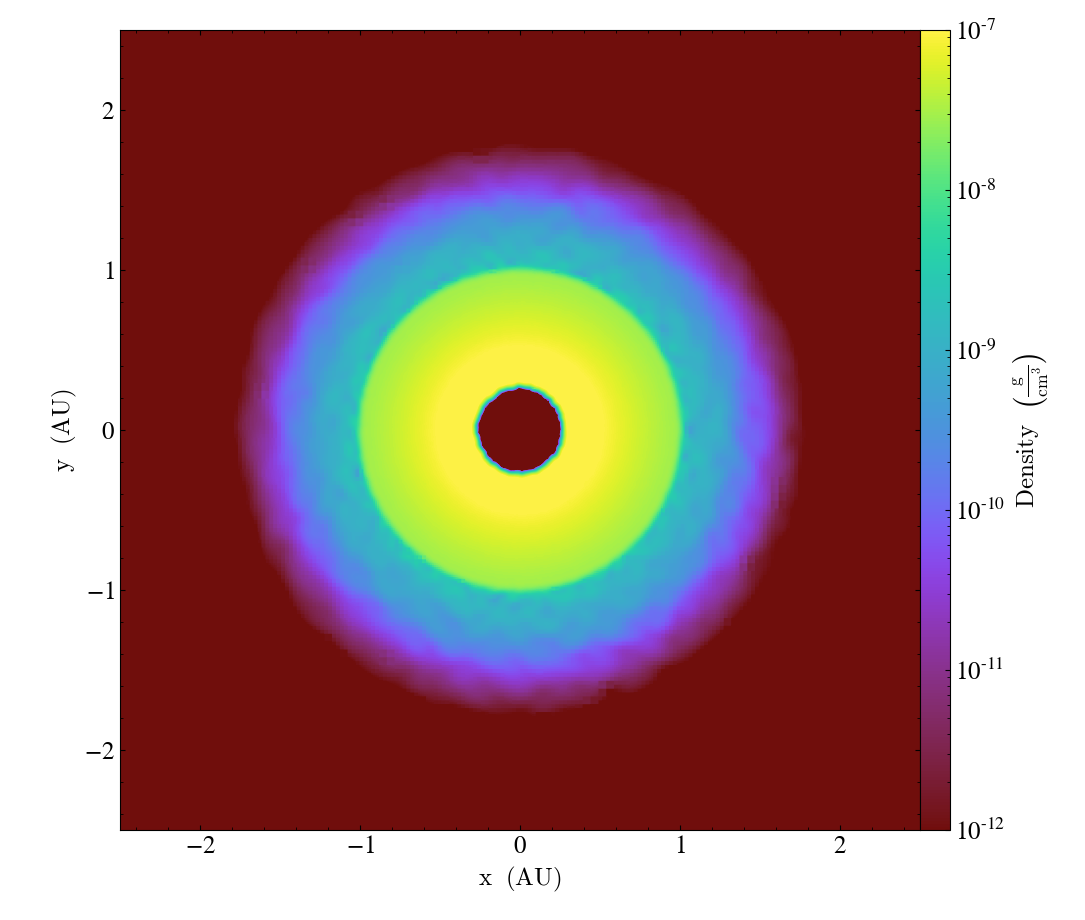

In [13]:
s.set_zlim('density',1e-12,1e-7)
s.show()